# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import statsmodels.api as sm
import seaborn as sn
import gmaps
import json
from scipy.stats import sem,chisquare
from scipy.stats import linregress
from api_keys import g_key
from matplotlib import cm

# Import Google Maps API Key

In [2]:
gmaps.configure(api_key=g_key)

# Import Crime Data

In [3]:
filepath = "Resources/merged_final.csv"
df = pd.read_csv(filepath, low_memory=False)

df.head(3)

,Unnamed: 0,Census_Tract,Pct_Pop_Below_Pov,Pct_Child_Below_Pov,Offense,Method,Latitude,Longitude,Start_Date,CCN
0,0,201,100.0,25.055524,THEFT/OTHER,OTHERS,38.912577,-77.073401,2017-10-18 17:00:00+00:00,17401735
1,1,201,100.0,25.055524,THEFT/OTHER,OTHERS,38.912603,-77.074958,2017-11-20 05:55:00+00:00,17401924
2,2,201,100.0,25.055524,THEFT/OTHER,OTHERS,38.910192,-77.069144,2017-07-18 18:15:00+00:00,17401306


# Find Null Values

### Identify Columns with NaN

In [4]:
count_nan_in_df = df.isnull().sum()
#print (count_nan_in_df)
count_nan_in_df

Unnamed: 0             0
Census_Tract           0
Pct_Pop_Below_Pov      0
Pct_Child_Below_Pov    0
Offense                0
Method                 0
Latitude               0
Longitude              0
Start_Date             0
CCN                    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19759 entries, 0 to 19758
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           19759 non-null  int64  
 1   Census_Tract         19759 non-null  int64  
 2   Pct_Pop_Below_Pov    19759 non-null  float64
 3   Pct_Child_Below_Pov  19759 non-null  float64
 4   Offense              19759 non-null  object 
 5   Method               19759 non-null  object 
 6   Latitude             19759 non-null  float64
 7   Longitude            19759 non-null  float64
 8   Start_Date           19759 non-null  object 
 9   CCN                  19759 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 1.5+ MB


# Convert Date Columns to Date Type

In [6]:
df['Start_Date'] = pd.to_datetime(df['Start_Date'], format='%Y-%m-%dT%H:%M:%S.%f')

### Confirm Columns are now Timestamps

In [7]:
df['Start_Date'][1]

Timestamp('2017-11-20 05:55:00+0000', tz='UTC')

# Convert Census_Tract Column to String

In [8]:
df['Census_Tract'] = df['Census_Tract'].astype(str)
type(df['Census_Tract'][1])

str

# Plot TimeSeries Of Crime

### Filter for 2017 Data Only

In [9]:
mask = df['Start_Date'] > '2017-01-01 00:00:00+0000'

In [10]:
df_2017 = df.loc[mask]
df_2017.sort_values('Start_Date', ascending=False, inplace=True)
df_2017.drop('Unnamed: 0', axis=1, inplace=True)
df_2017.reset_index(drop=True, inplace=True)
df_2017.tail(3)

/home/bdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/bdr/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Census_Tract,Pct_Pop_Below_Pov,Pct_Child_Below_Pov,Offense,Method,Latitude,Longitude,Start_Date,CCN
19612,9301,10.4,1.4,THEFT F/AUTO,OTHERS,38.928129,-76.980002,2017-01-01 00:30:20+00:00,17000271
19613,7804,28.4,52.9,BURGLARY,OTHERS,38.898344,-76.926567,2017-01-01 00:01:46+00:00,17002228
19614,5201,7.1,0.0,THEFT F/AUTO,OTHERS,38.907235,-77.033262,2017-01-01 00:01:38+00:00,17068950


### Validation: Output Most Recent Timestamp

In [11]:
df_2017['Start_Date'].max()

Timestamp('2017-12-31 21:47:23+0000', tz='UTC')

### Filter for January 2017 Data Only

In [12]:
mask_Jan = df_2017['Start_Date'] < '2017-01-31 00:00:00+0000'
df_January = df_2017.loc[mask_Jan]
df_January.reset_index(drop=True, inplace=True)
df_January.tail(3)

,Census_Tract,Pct_Pop_Below_Pov,Pct_Child_Below_Pov,Offense,Method,Latitude,Longitude,Start_Date,CCN
1779,9301,10.4,1.4,THEFT F/AUTO,OTHERS,38.928129,-76.980002,2017-01-01 00:30:20+00:00,17000271
1780,7804,28.4,52.9,BURGLARY,OTHERS,38.898344,-76.926567,2017-01-01 00:01:46+00:00,17002228
1781,5201,7.1,0.0,THEFT F/AUTO,OTHERS,38.907235,-77.033262,2017-01-01 00:01:38+00:00,17068950


### Incidence of Crime by Time of Day (2017): ColorMap Bar Chart

In [13]:
#Groupby 'Start_Date' by day
crime_hour_df = df_2017.groupby(df_2017["Start_Date"].dt.hour)["CCN"].count()
crime_hour_df = pd.DataFrame(crime_hour_df)
crime_hour_df.sort_values('CCN', ascending=False, inplace=True)

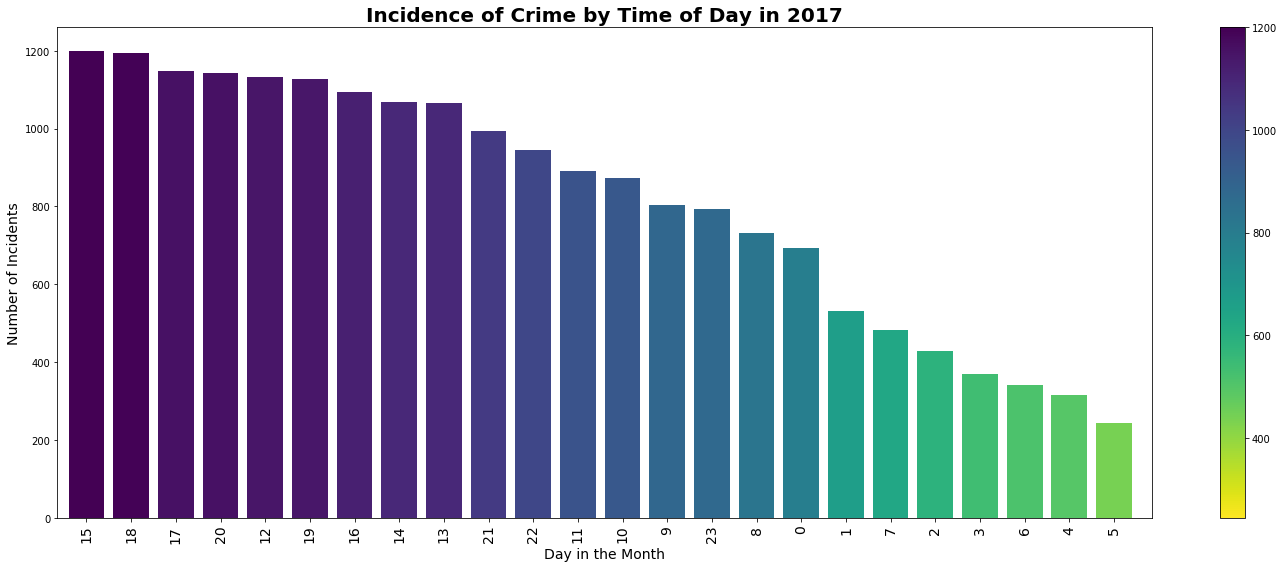

In [14]:
#Create x axis
x_axis = np.arange(len(crime_hour_df))

#Figure Size
plt.figure(figsize=(20,8))

#Colourmap legend (reverse colour_map: viridis_r)
plot = plt.scatter(crime_hour_df.CCN, crime_hour_df.CCN, c = crime_hour_df.CCN, cmap = 'viridis_r')
plt.clf()
plt.colorbar(plot)

#Colourmap (reverse colour map:)
colors = cm.viridis_r(crime_hour_df.CCN / float(max(crime_hour_df.CCN)))

tick_locations = [value+0.4 for value in x_axis]

#Plot Graph
plt.bar(x_axis, crime_hour_df.CCN, color=colors, alpha=1.0, align="edge")
plt.xticks(tick_locations, crime_hour_df.index, rotation="vertical", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xlabel("Day in the Month", fontsize=14)
plt.title("Incidence of Crime by Time of Day in 2017", fontsize=20, fontweight="bold")
plt.xlim(-0.25, len(crime_hour_df)+0.25)
plt.tight_layout()

#Export Graph to File
plt.savefig("Images/Incidence_of_Crime_by_Hour_2017.png")
plt.show()

### Incidence of Crime by Weekday (2017): ColorMap Bar Chart

- week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html

In [15]:
weekday = ['Monday', 'Tuesday', 'Wednesday','Thursday',
         'Friday', 'Saturday', 'Sunday']

In [16]:
#Groupby 'Start_Date' by Weekday
crime_weekday_df = df_2017.groupby(df_2017["Start_Date"].dt.dayofweek)["CCN"].count()
crime_weekday_df = pd.DataFrame(crime_weekday_df)
#Create Months Column
crime_weekday_df["Weekday"] = weekday
#Set Months as new Index
crime_weekday_df.set_index('Weekday', inplace=True)
crime_weekday_df.sort_values('CCN', ascending=False, inplace=True)

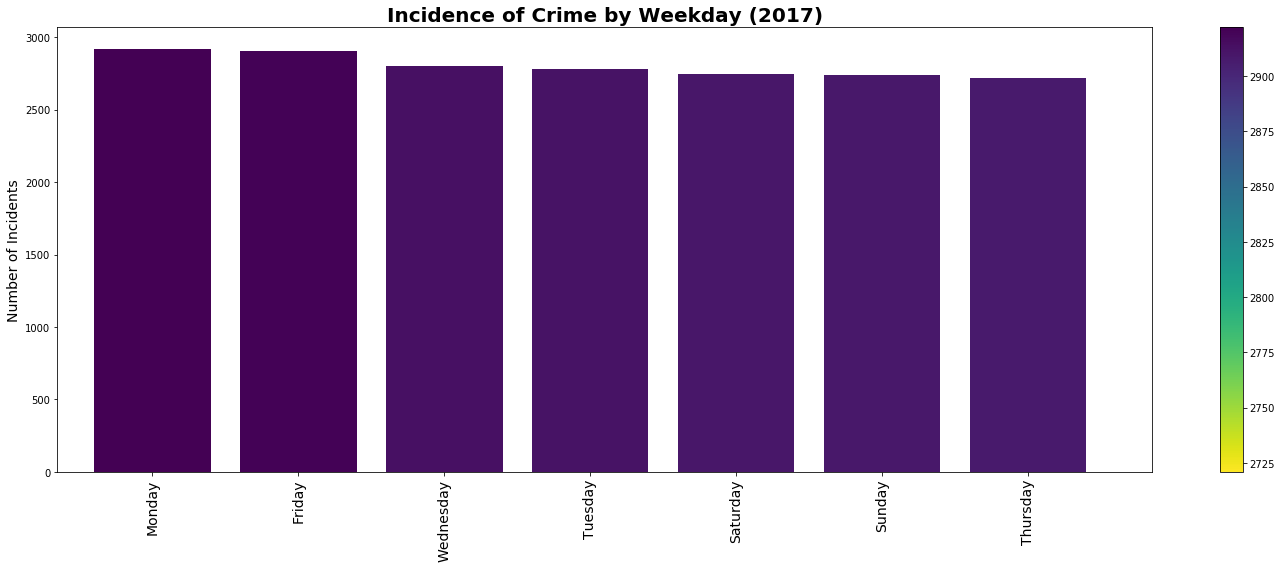

In [17]:
#Create x axis
x_axis = np.arange(len(crime_weekday_df))

#Figure Size
plt.figure(figsize=(20,8))

#Colourmap legend (reverse colour_map: viridis_r)
plot = plt.scatter(crime_weekday_df.CCN, crime_weekday_df.CCN, c = crime_weekday_df.CCN, cmap = 'viridis_r')
plt.clf()
plt.colorbar(plot)

#Colourmap (reverse colour map:)
colors = cm.viridis_r(crime_weekday_df.CCN / float(max(crime_weekday_df.CCN)))

tick_locations = [value+0.4 for value in x_axis]

#Plot Graph
plt.bar(crime_weekday_df.index, crime_weekday_df.CCN, color=colors, alpha=1.0, align="edge")
plt.xticks(tick_locations, crime_weekday_df.index, rotation="vertical", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
#plt.xlabel("Day in the Month", fontsize=14)
plt.title("Incidence of Crime by Weekday (2017)", fontsize=20, fontweight="bold")
plt.xlim(-0.25, len(crime_weekday_df)+0.25)
plt.tight_layout()

#Export Graph to File
plt.savefig("Images/Incidence_of_Crime_by_Weekday_2017.png")
plt.show()

### Incidence of Crime by Day of Month (2017): ColorMap Bar Chart

In [18]:
#Groupby 'Start_Date' by day
crime_day_df = df_2017.groupby(df_2017["Start_Date"].dt.day)["CCN"].count()
crime_day_df = pd.DataFrame(crime_day_df)
crime_day_df.sort_values('CCN', ascending=False, inplace=True)

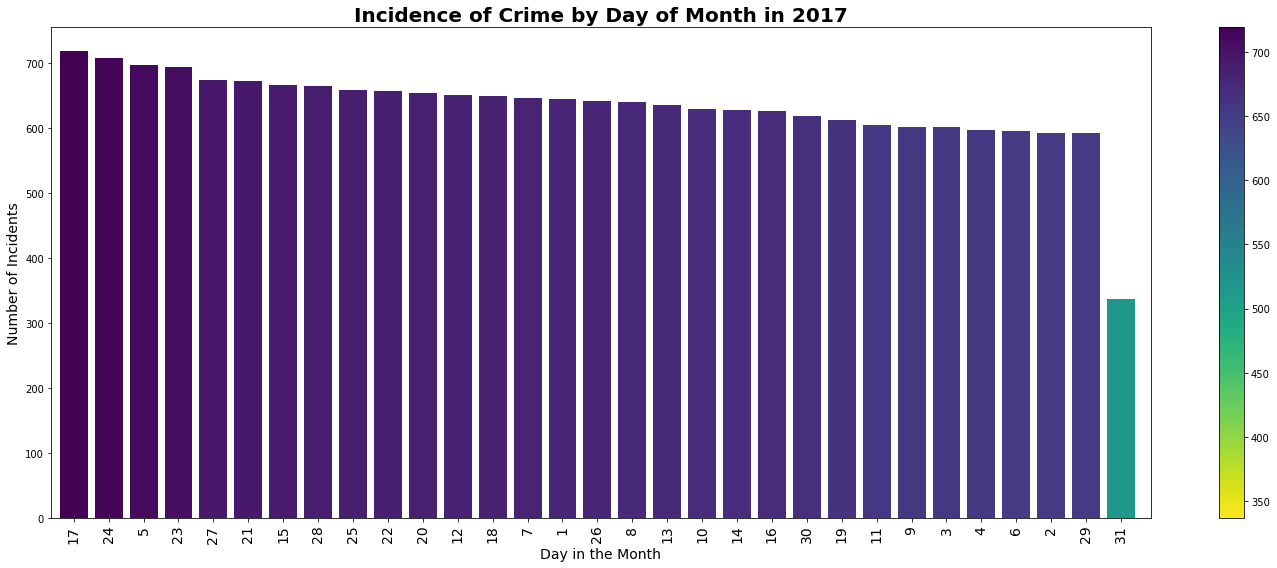

In [19]:
#Create x axis
x_axis = np.arange(len(crime_day_df))

#Figure Size
plt.figure(figsize=(20,8))

#Colourmap legend (reverse colour_map: viridis_r)
plot = plt.scatter(crime_day_df.CCN, crime_day_df.CCN, c = crime_day_df.CCN, cmap = 'viridis_r')
plt.clf()
plt.colorbar(plot)

#Colourmap (reverse colour map:)
colors = cm.viridis_r(crime_day_df.CCN / float(max(crime_day_df.CCN)))

tick_locations = [value+0.4 for value in x_axis]

#Plot Graph
plt.bar(x_axis, crime_day_df.CCN, color=colors, alpha=1.0, align="edge")
plt.xticks(tick_locations, crime_day_df.index, rotation="vertical", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xlabel("Day in the Month", fontsize=14)
plt.title("Incidence of Crime by Day of Month in 2017", fontsize=20, fontweight="bold")
plt.xlim(-0.25, len(crime_day_df)+0.25)
plt.tight_layout()

#Export Graph to File
plt.savefig("Images/Incidence_of_Crime_by_Day_2017.png")
plt.show()

### Incidence of Crime by Month of the Year (2017): ColorMap Bar Chart

In [20]:
months = ['January', 'February', 'March','April',
         'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']

In [21]:
#Groupby 'Start_Date' by Month
crime_month_df = df_2017.groupby(df_2017["Start_Date"].dt.month)["CCN"].count()
crime_month_df = pd.DataFrame(crime_month_df)
#Create Months Column
crime_month_df["Months"] = months
#Set Months as new Index
crime_month_df.set_index('Months', inplace=True)
crime_month_df.sort_values('CCN', ascending=False, inplace=True)

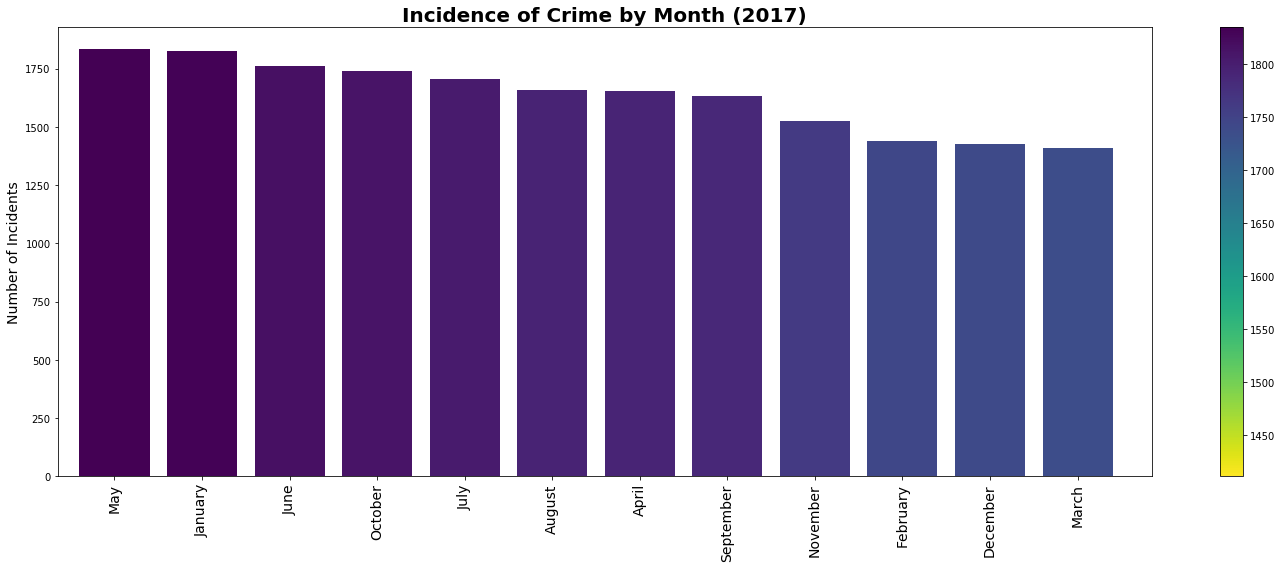

In [22]:
#Create x axis
x_axis = np.arange(len(crime_month_df))

#Figure Size
plt.figure(figsize=(20,8))

#Colourmap legend (reverse colour_map: viridis_r)
plot = plt.scatter(crime_month_df.CCN, crime_month_df.CCN, c = crime_month_df.CCN, cmap = 'viridis_r')
plt.clf()
plt.colorbar(plot)

#Colourmap (reverse colour map:)
colors = cm.viridis_r(crime_month_df.CCN / float(max(crime_month_df.CCN)))

tick_locations = [value+0.4 for value in x_axis]

#Plot Graph
plt.bar(crime_month_df.index, crime_month_df.CCN, color=colors, alpha=1.0, align="edge")
plt.xticks(tick_locations, crime_month_df.index, rotation="vertical", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
#plt.xlabel("Day in the Month", fontsize=14)
plt.title("Incidence of Crime by Month (2017)", fontsize=20, fontweight="bold")
plt.xlim(-0.25, len(crime_month_df)+0.25)
plt.tight_layout()

#Export Graph to File
plt.savefig("Images/Incidence_of_Crime_by_Month_2017.png")
plt.show()

# Overview of Data

In [23]:
df_2017.describe()

,Pct_Pop_Below_Pov,Pct_Child_Below_Pov,Latitude,Longitude,CCN
count,19615.000000,19615.000000,19615.000000,19615.000000,1.961500e+04
mean,20.277675,25.101593,38.905307,-76.997621,1.711939e+07
std,13.018253,21.236977,0.032447,0.039392,1.525146e+05
min,0.000000,0.000000,38.822921,-77.112316,2.111617e+06
25%,10.400000,1.200000,38.890132,-77.026680,1.705782e+07
50%,17.900000,24.500000,38.905065,-76.995573,1.711492e+07
75%,28.400000,44.400000,38.924454,-76.975410,1.717292e+07
max,100.000000,77.100000,38.977783,-76.910021,2.709178e+07


In [24]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Census_Tract         19615 non-null  object             
 1   Pct_Pop_Below_Pov    19615 non-null  float64            
 2   Pct_Child_Below_Pov  19615 non-null  float64            
 3   Offense              19615 non-null  object             
 4   Method               19615 non-null  object             
 5   Latitude             19615 non-null  float64            
 6   Longitude            19615 non-null  float64            
 7   Start_Date           19615 non-null  datetime64[ns, UTC]
 8   CCN                  19615 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(3)
memory usage: 1.3+ MB


# Create Google Map of Crime

### Create Heatmap based on Crime by Census Tract

- Aggregate Crime Statistics by Census Tract, Latitude & Longitude

In [25]:
maps_df = df_2017.groupby(['Census_Tract', 'Latitude', 'Longitude']).count()['CCN']
maps_df = pd.DataFrame(maps_df)
maps_df.reset_index(inplace=True)
maps_df.head()

,Census_Tract,Latitude,Longitude,CCN
0,1001,38.941043,-77.086707,1
1,1001,38.941068,-77.089141,1
2,1001,38.942214,-77.087286,1
3,1001,38.942691,-77.087771,1
4,1001,38.943156,-77.091624,1


In [26]:
locations = maps_df[['Latitude','Longitude']]

num_of_crimes = maps_df.CCN

figure_layout = {
    'width': '950px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

fig = gmaps.figure(map_type="HYBRID", layout=figure_layout)
heat_layer = gmaps.heatmap_layer(locations, weights=num_of_crimes, dissipating=True)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

# Types of Offenses

- Here is a list of the various types of crime.

In [27]:
df_2017.Offense.unique()

array(['ASSAULT W/DANGEROUS WEAPON', 'THEFT/OTHER', 'THEFT F/AUTO',
       'MOTOR VEHICLE THEFT', 'ROBBERY', 'SEX ABUSE', 'BURGLARY',
       'HOMICIDE', 'ARSON'], dtype=object)

### Volume of Crime by Type

In [28]:
offense_type = df_2017.groupby(['Offense']).count()['CCN']
offense_type = pd.DataFrame(offense_type)
offense_type.sort_values('CCN', ascending=False, inplace=True)
offense_type = offense_type.rename(columns={'CCN': 'Frequency in 2017'})
offense_type.index.names = ['Type of Crime']
offense_type

,Frequency in 2017
Type of Crime,
THEFT/OTHER,8170
THEFT F/AUTO,5538
MOTOR VEHICLE THEFT,1692
ROBBERY,1494
ASSAULT W/DANGEROUS WEAPON,1405
BURGLARY,1025
SEX ABUSE,194
HOMICIDE,94
ARSON,3


# Pie Chart: Types of Weapon

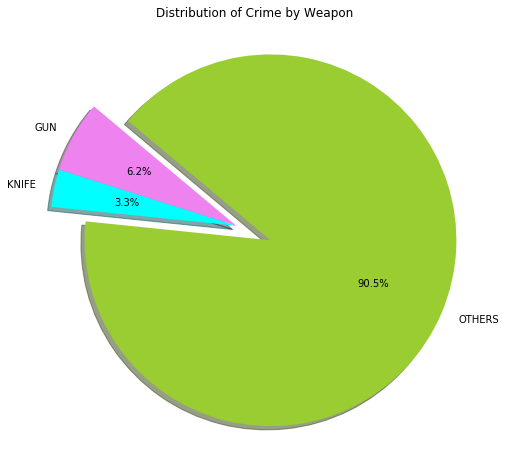

In [29]:
labels = ['GUN', 'KNIFE', 'OTHERS']
sizes = df_2017.groupby(['Method'])["CCN"].count()
colors = ["violet", "aqua", "yellowgreen"]
explode = (0, 0, 0.2)

plt.figure(figsize=(8, 8))
plt.title("Distribution of Crime by Weapon")
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.axis("equal")
plt.savefig('Images/Pie_Chart_Type_of_Weapon.png')
plt.show()

# Histograms

### Create Function to Plot Histogram

In [30]:
def matplotHistogram(col, df):

    #Plot Bar Chart
    plt.figure(figsize=(8, 8))
    plt.hist(df[col], 100, color='indigo', alpha=0.75)
    #plt.xticks(rotation=90)
    plt.title(f"Washington Crime Statistics 2017 by {col}", fontsize=16, fontweight="bold")
    plt.xlabel(f"{col}")
    plt.ylabel("Frequency of Offences")
    axes = plt.gca()
    axes.yaxis.grid()
    plt.savefig(f'Images/Histogram_{col}.png')
    plt.show()

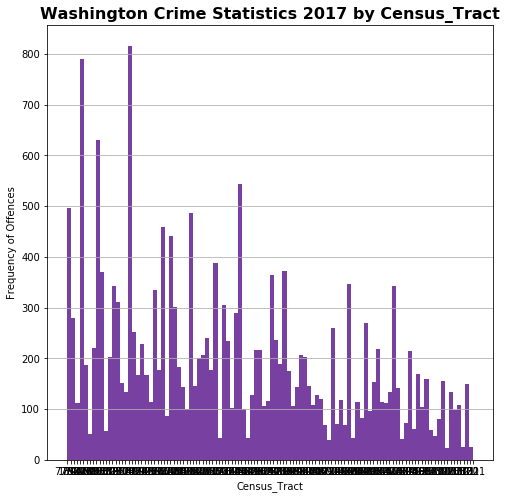

In [31]:
matplotHistogram('Census_Tract', df_2017)

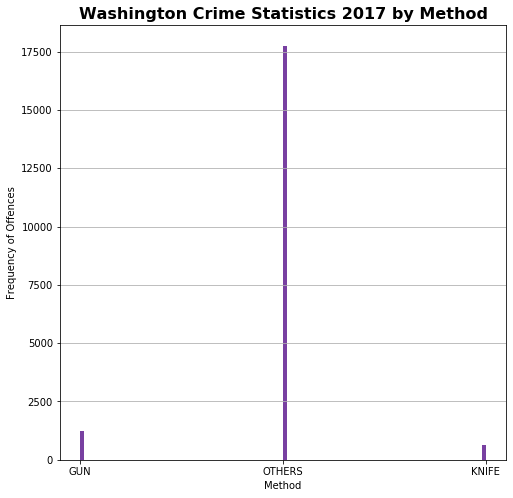

In [32]:
matplotHistogram('Method', df_2017)

In [33]:
df_2017.columns

Index(['Census_Tract', 'Pct_Pop_Below_Pov', 'Pct_Child_Below_Pov', 'Offense',
       'Method', 'Latitude', 'Longitude', 'Start_Date', 'CCN'],
      dtype='object')

### Create Histograms for Each Column

In [34]:
cols = ['Report', 'Shift', 'Method', 'Offense', 'Block', 'XBlock',
       'YBlock', 'Ward', 'ANC', 'District', 'PSA', 'Neighborhood',
       'Block_Grou', 'Census_Trac', 'Voting_Precinct', 'Latitude', 
        'Longitude', 'Object_ID', 'Octo_Recor']

- Graphs indicate that none of these variable demonstrate a normal distribution 

In [35]:
#for col in cols:
#    matplotHistogram(col,renamed_df)

# Bar Charts

### Create Function to Plot Bar Chart

In [36]:
def matplotBarChart(col, df):
    #Groupby operation on Target Column
    #Assign to temporarily DataFrame
    #Sort & capture top 10
    sub_df = df.groupby([col]).count()['CCN']
    sub_df = pd.DataFrame(sub_df)
    sub_df.sort_values('CCN', ascending=False, inplace=True)
    sub_df = sub_df.head(10)

    #Plot Bar Chart
    plt.figure(figsize=(8, 8))
    plt.bar(sub_df.index, sub_df['CCN'], color='indigo', align="center")
    plt.xticks(rotation=90)
    plt.title(f"Washington Crime Statistics 2017 by {col}", fontsize=16, fontweight="bold")
    plt.xlabel(f"{col}")
    plt.ylabel("Number of Offences")
    axes = plt.gca()
    axes.yaxis.grid()
    plt.savefig(f'Images/Bar_Chart_{col}.png')
    plt.show

### Crime by Type of Offense

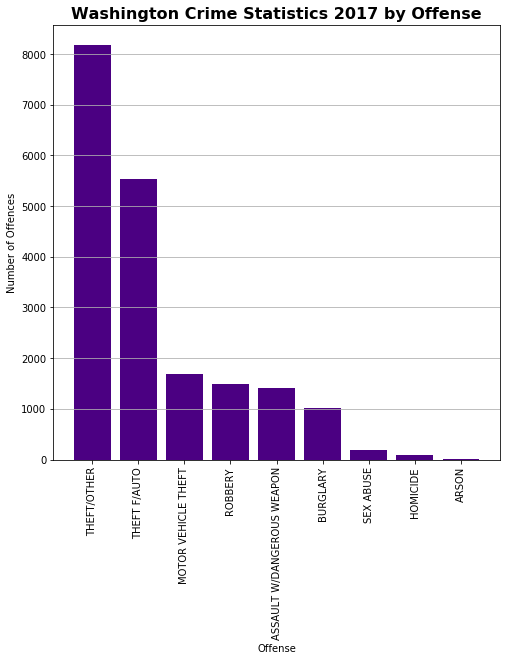

In [37]:
matplotBarChart('Offense', df_2017)

### Crime by Census Tract

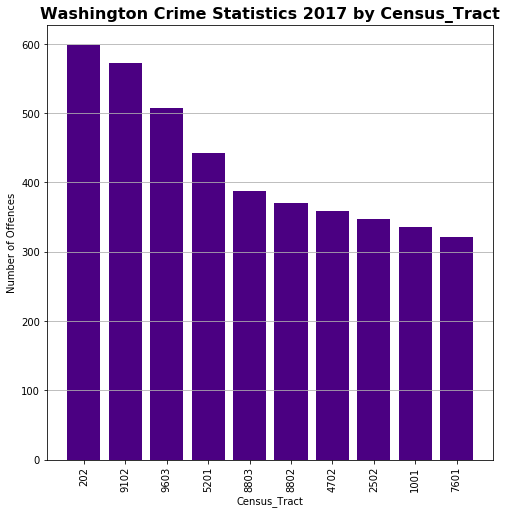

In [38]:
matplotBarChart('Census_Tract', df_2017)

# Crime by Weapon

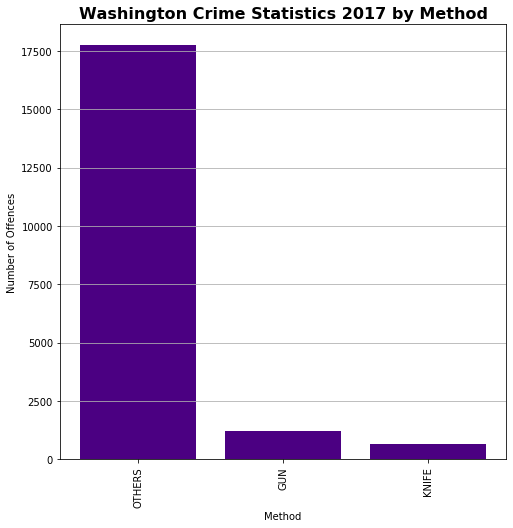

In [39]:
matplotBarChart('Method', df_2017)

# Correlation

Many of the fields in this dataset were related to location (e.g. XBlock, Ward,Census Tract, Voting Precinct, Latitude, Longitude).
Consequently, it was difficult to find meaningful correlations.

In [40]:
df_2017.corr()

,Pct_Pop_Below_Pov,Pct_Child_Below_Pov,Latitude,Longitude,CCN
Pct_Pop_Below_Pov,1.000000,0.862961,-0.537340,0.419328,-0.018416
Pct_Child_Below_Pov,0.862961,1.000000,-0.522453,0.500101,-0.027470
Latitude,-0.537340,-0.522453,1.000000,-0.479755,0.019087
Longitude,0.419328,0.500101,-0.479755,1.000000,-0.027438
CCN,-0.018416,-0.027470,0.019087,-0.027438,1.000000


### Heatmap to Illustrate Correlation

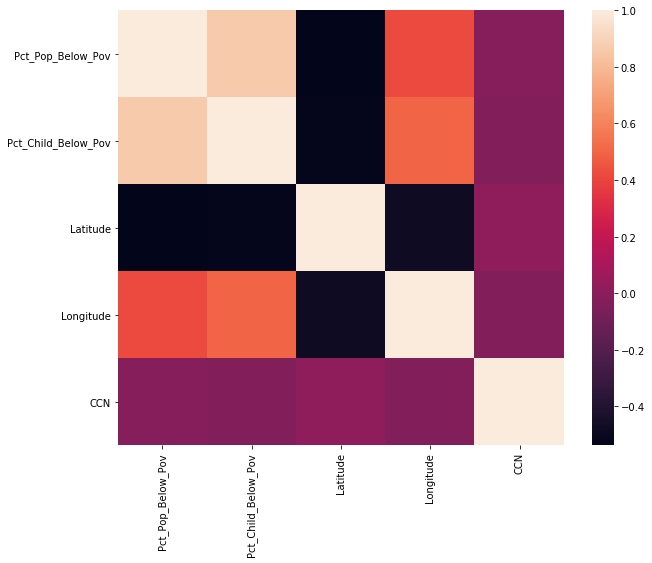

In [41]:
plt.figure(figsize=(10, 8))
sn.heatmap(df_2017.corr())
plt.savefig('Images/Correlation_HeatMap.png')
plt.show()

# Scatter Plots

As discussed above, scatter plots do not illustrate any meaning correlations

### Function to Create Scatter Plot

In [42]:
def makeScatter(col1, col2, df):  
    plt.figure(figsize=(8, 8))
    plt.scatter(df[col1], df[col2], c="blueviolet", edgecolors="black", alpha=0.35)
    plt.title(f"{col1.title()} vs {col2.title()}")
    plt.xlabel(f"{col1.title()}")
    plt.ylabel(f"{col2.title()}")
    plt.tight_layout
    plt.show()

### Create List of Variables for Scatter Plots

In [43]:
df_2017.columns

Index(['Census_Tract', 'Pct_Pop_Below_Pov', 'Pct_Child_Below_Pov', 'Offense',
       'Method', 'Latitude', 'Longitude', 'Start_Date', 'CCN'],
      dtype='object')

In [44]:
cols = ['Census_Tract', 'Pct_Pop_Below_Pov', 'Pct_Child_Below_Pov', 'Offense',
       'Method', 'Latitude', 'Longitude', 'Start_Date', 'CCN']

### Create Scatter Plots for Census Trac

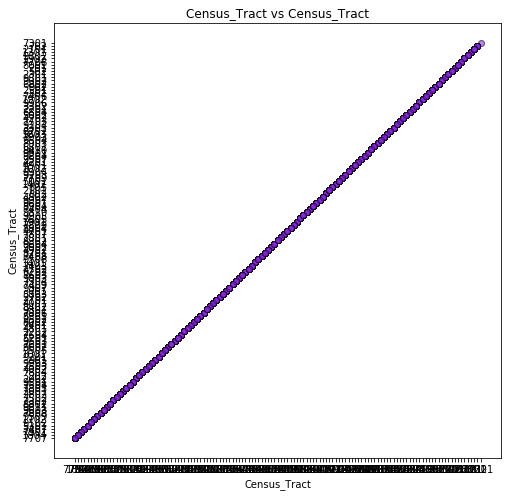

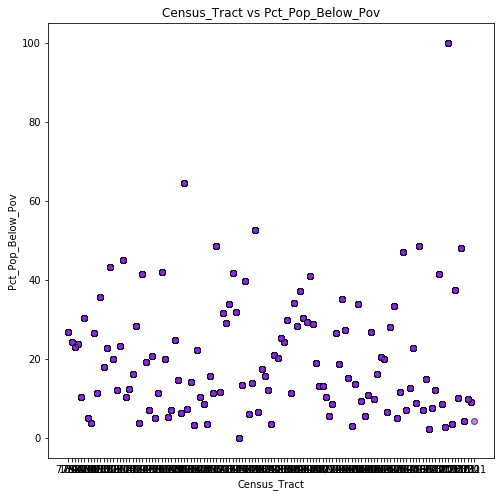

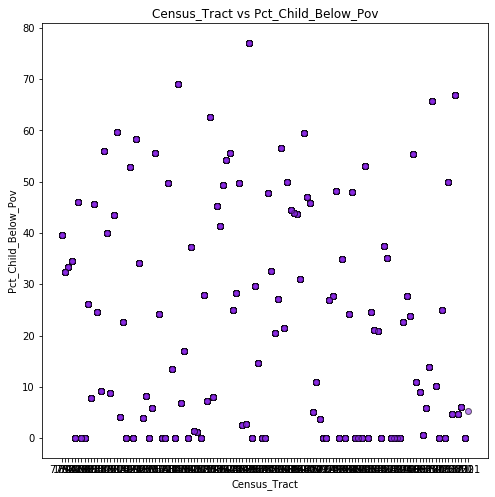

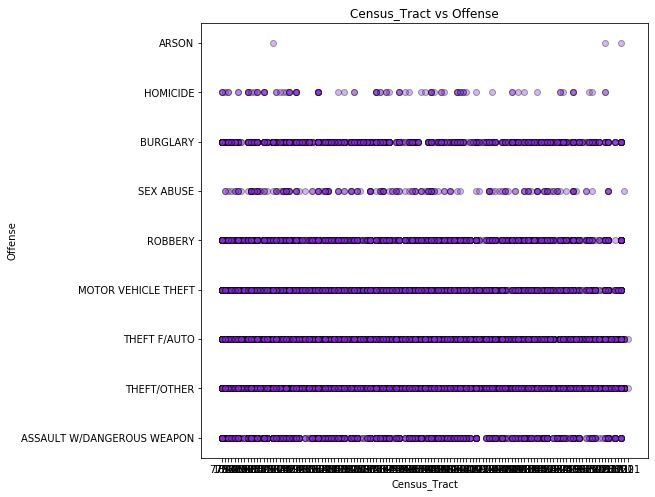

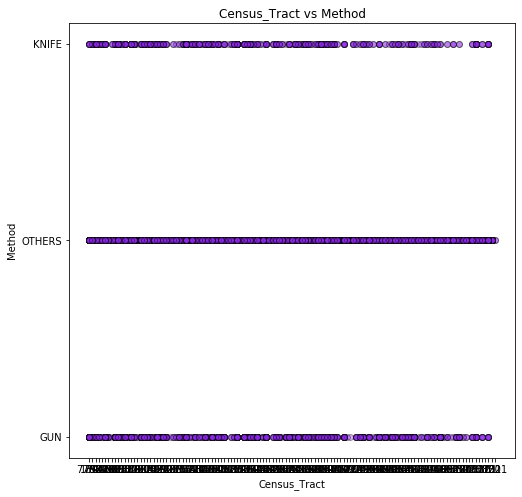

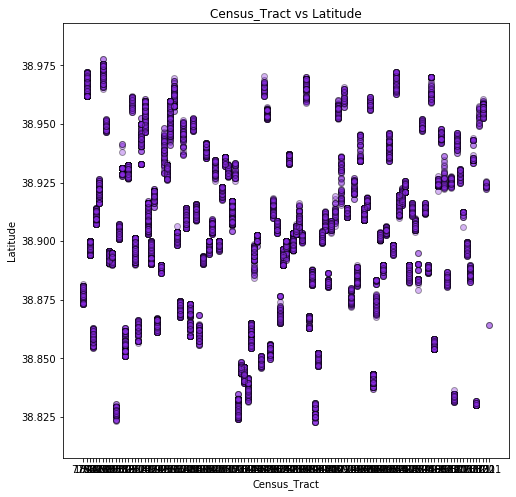

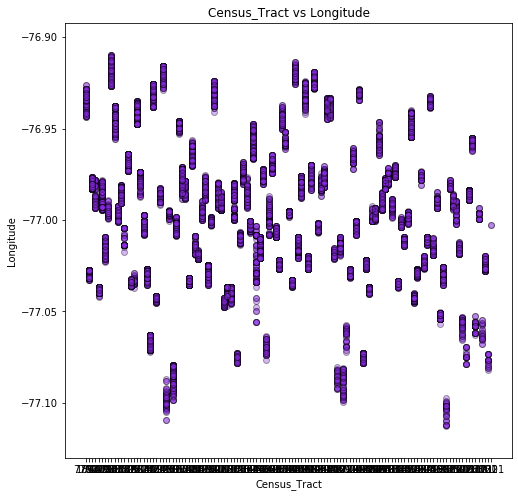

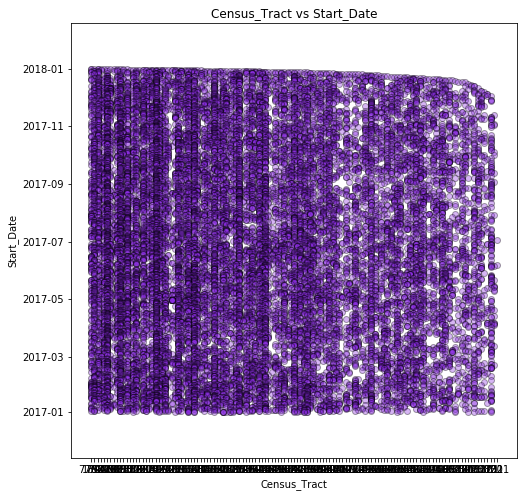

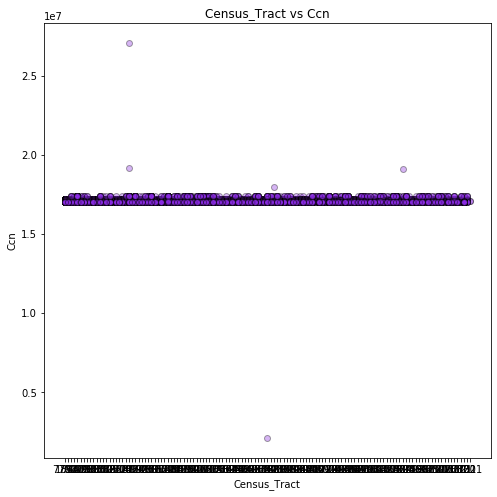

In [45]:
for col in cols:
    makeScatter("Census_Tract", col, df_2017)

# Chisquared Analysis

In [46]:
rr_df = df_2017.groupby(df_2017.Census_Tract).count()['CCN']
rr_df

sub_df = pd.DataFrame(rr_df)
sub_df.sort_values('CCN', ascending=False, inplace=True)
sub_df = sub_df.head(10)
sub_df

,CCN
Census_Tract,
202,598
9102,572
9603,508
5201,442
8803,387
8802,370
4702,359
2502,347
1001,335


In [47]:
(sub_df['CCN'].sum())/10

423.9

In [48]:
sub_df["Expected"]=643.2

In [49]:
chisquare(sub_df['CCN'],sub_df['Expected'])

Power_divergenceResult(statistic=891.5637437810947, pvalue=4.06529994606606e-186)

In [50]:
new_list =[1000, 850, 650, 630, 630, 600, 550, 500, 450, 450]
sub_df['Expected']= new_list
sub_df

,CCN,Expected
Census_Tract,,
202,598,1000
9102,572,850
9603,508,650
5201,442,630
8803,387,630
8802,370,600
4702,359,550
2502,347,500
1001,335,450


In [51]:
chisquare(sub_df['CCN'],sub_df['Expected'])

Power_divergenceResult(statistic=701.0606965975201, pvalue=4.0911466407070204e-145)